In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

import itertools

In [2]:
import matplotlib.pyplot as plt

In [219]:
world = WorldConfig(field_sizes={"v": 5, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 1, 'tt': 6, 'hh': 4, 'ww': 4}, batch_size=16)

In [220]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256, dim_coords=64,
                        wavelengths=[(1,8),(1,8),(1,64),(1,128)])

In [221]:
class HeuristicMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        # min/max rates
        self.src_min = objective.c0_src
        self.src_max = objective.c1_src
        self.tgt_min = objective.c0_tgt
        self.tgt_max = objective.c1_tgt

        self.c1_prior = objective.c1_prior

        # attributes
        self.k_min = default(objective.k_min, 1)
        self.k_max = default(objective.k_max, world.num_tokens // world.token_sizes['v'])

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.register_buffer('num_events', torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod())
        self.event_pattern = f'({" ".join(objective.event_dims)})'

    def forward(self, shape: tuple, rng: torch.Generator = None):
        u = torch.rand((2, *shape, self.num_events), generator = rng, device = self.num_events.device)
        p = torch.where(u[0] > self.c1_prior, u[1].clamp(0.1, 0.9), 1e-16)
        
        p = einops.repeat(p,
            f'... {self.event_pattern} -> ... (t h w)', 
            t = self.world.token_sizes['t'], h = self.world.token_sizes['h'], w = self.world.token_sizes['w']
            )

        rs = torch.rand((2, self.world.token_sizes['v']), generator = rng, device = self.num_events.device)
        r_src = self.src_min + (self.src_max - self.src_min) * rs[0]
        r_tgt = self.tgt_min + (self.tgt_max - self.tgt_min) * rs[1]

        src = torch.cat([torch.multinomial(p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_src)], dim = -1)
        tgt = torch.cat([torch.multinomial(1 - p, int(r * self.k_max), generator=rng) + i * self.k_max for i, r in enumerate(r_tgt)], dim = -1)

        return src, tgt, None, None


In [382]:
class MultinomialMasking(torch.nn.Module):
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        #schedule
        self.src_rates = StableKumaraswamy(c0=objective.c0_src, c1=objective.c1_src)
        self.tgt_rates = StableKumaraswamy(c0=objective.c0_tgt, c1=objective.c1_tgt)
        self.prior = StableKumaraswamy(c0=objective.c0_prior, c1= objective.c1_prior)

        # attributes
        self.k_min = default(objective.k_min, 1)
        self.k_max = default(objective.k_max, world.num_tokens)

        # Events
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'
        self.num_events = torch.tensor([world.token_sizes[d] for d in objective.event_dims]).prod()
        self.event_pattern = f'({" ".join(objective.event_dims)})'

    def expand_events(self, *args):
        return einops.repeat(
            [*args],
            f'args ... {self.event_pattern} -> args ... {self.world.flat_token_pattern}', 
            **self.world.token_sizes
            )
    
    def k_from_rates(self, r: float):
        return int(self.k_min + (self.k_max - self.k_min) * r)

    def forward(self, shape: tuple, rng: torch.Generator = None):
        # sample prior
        t = torch.rand((*shape, self.num_events), device=self.num_events.device, generator= rng)
        t = t * (1.0 - 2.0 * self.prior.epsilon) + self.prior.epsilon
        psrc, ptgt = self.prior.quantile(t), self.prior.quantile(1 - t)
        psrc, ptgt = self.expand_events(psrc, ptgt)
        
        # sample rates
        r_src, _ = self.src_rates((1,), rng)
        r_tgt, _ = self.tgt_rates((1,), rng)

        # sample indices
        src = torch.multinomial(psrc, self.k_from_rates(r_src), generator=rng)
        tgt = torch.multinomial(ptgt, self.k_from_rates(r_tgt), generator = rng)
        return src, tgt, None, None

In [446]:
0.5/3

0.16666666666666666

In [402]:
a=64/2304
b = 768/2304
c =1536/2304

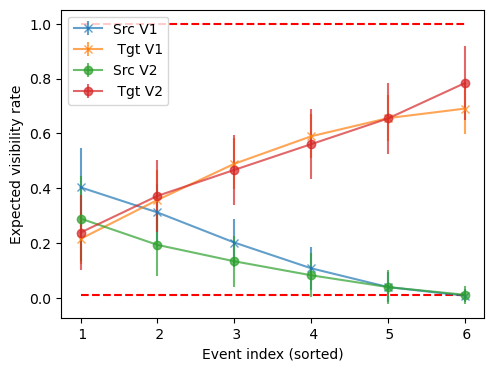

In [427]:
hm = HeuristicMasking(world, objective=ObjectiveConfig( c1_prior=0.3, c1_src=b, c0_src=a, c1_tgt=c, c0_tgt=b))
N = world.num_tokens // world.token_sizes['t']
srcs, tgts = [], []
for _ in range(1000):
    src, tgt, _, _ = hm((1,))
    sm = torch.unravel_index(src, world.token_shape)[1].squeeze().bincount(minlength=6) / N
    tm = torch.unravel_index(tgt, world.token_shape)[1].squeeze().bincount(minlength=6) / N
    srcs.append(sm)
    tgts.append(tm)
srcs = torch.stack(srcs)
tgts = torch.stack(tgts)

rsrc_hm = srcs.sort(dim=1, descending=True).values
rtgt_hm = tgts.sort(dim=1, descending=False).values

mm = MultinomialMasking(world, 
                        objective=ObjectiveConfig(c1_prior=0.05,   
                                                  c1_src=1.6, c0_src=24, c1_tgt=6, c0_tgt=32,
                                                  event_dims=['t', 'v']))

srcs, tgts = [], []
for _ in range(1000):
    src, tgt, _, _ = mm((1,))
    sm = torch.unravel_index(src, world.token_shape)[1].squeeze().bincount(minlength=6) / N
    tm = torch.unravel_index(tgt, world.token_shape)[1].squeeze().bincount(minlength=6) / N
    srcs.append(sm)
    tgts.append(tm)
srcs = torch.stack(srcs)
tgts = torch.stack(tgts)

rsrc_mm = srcs.sort(dim=1, descending=True).values
rtgt_mm = tgts.sort(dim=1, descending=False).values

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.errorbar(x = torch.arange(6), y = rsrc_hm.mean(dim=0), yerr=rsrc_hm.std(dim=0), fmt='x-', label='Src V1', alpha=0.7)
plt.errorbar(x = torch.arange(6), y = rtgt_hm.mean(dim=0), yerr=rtgt_hm.std(dim=0), fmt='x-', label=' Tgt V1', alpha=0.7)
plt.hlines(0.01, 0, 5, colors='red', linestyles='dashed')

plt.errorbar(x = torch.arange(6), y = rsrc_mm.mean(dim=0), yerr=rsrc_mm.std(dim=0), fmt='o-', label='Src V2', alpha=0.7)
plt.errorbar(x = torch.arange(6), y = rtgt_mm.mean(dim=0), yerr=rtgt_mm.std(dim=0), fmt='o-', label=' Tgt V2', alpha=0.7)

plt.ylabel('Expected visibility rate')
plt.xticks(ticks= torch.arange(6), labels= [f' {i+1}' for i in range(6)])
plt.xlabel('Event index (sorted)')
plt.legend()
plt.hlines(1, 0, 5, colors='red', linestyles='dashed')

In [296]:
c1tgt = 10
c0tgt = 30

1850.7358190629343

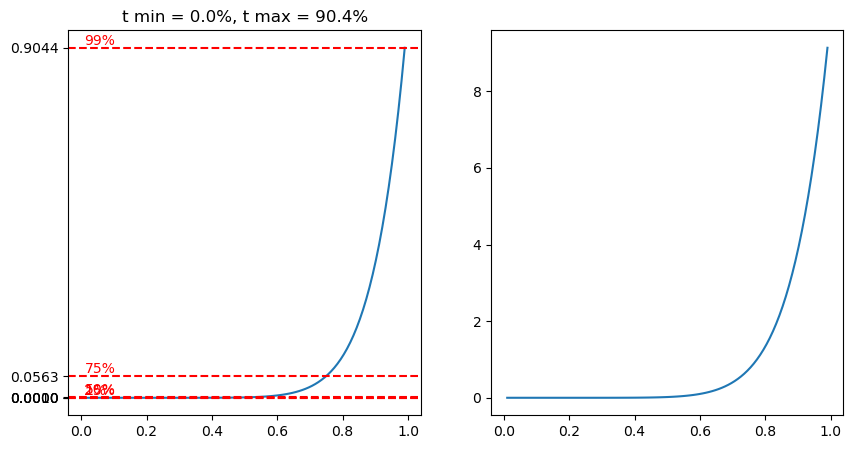

In [442]:
eps = 1e-2
u = torch.linspace(eps, 1 - eps,101)
c1 = 0.1
c0 = 1

k_min = 0
k_max = 1
km = StableKumaraswamy(c1=c1, c0=c0)
t = km.quantile(u)
t = k_min + (k_max - k_min) * t
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(u, t)
plt.title(f"t min = {100*t.min().item()/k_max:.1f}%, t max = {100*t.max().item()/k_max:.1f}%")
# add quantile lines
qtls = [u.min().item(), 0.25, 0.5, 0.75, u.max().item()]
for q in qtls:
    uq = torch.tensor(q).unsqueeze(0)
    tq = km.quantile(uq)
    tq = k_min + (k_max - k_min) * tq
    plt.axhline(tq.item(), color='red', linestyle='--')
    plt.text(0.01, tq.item(), f"{q*100:.0f}%", color='red', va='bottom')
# add tick marks on y axis at quantiles
plt.yticks([k_min + (k_max - k_min) * km.quantile(torch.tensor(q).unsqueeze(0)).item() for q in qtls])
plt.subplot(1,2,2)
plt.plot(u, km.quantile_dt(u))


In [334]:
print(f"min masking rate {100*t.max()/k_max:.1f}%, max masking rate {100*t.min()/k_max:.2f}%")
print(km.quantile_dt(u).max(), km.quantile_dt(u).min())

min masking rate 35.9%, max masking rate 0.45%
tensor(24.2465) tensor(0.1636)


Text(0, 0.5, 'masking rate')

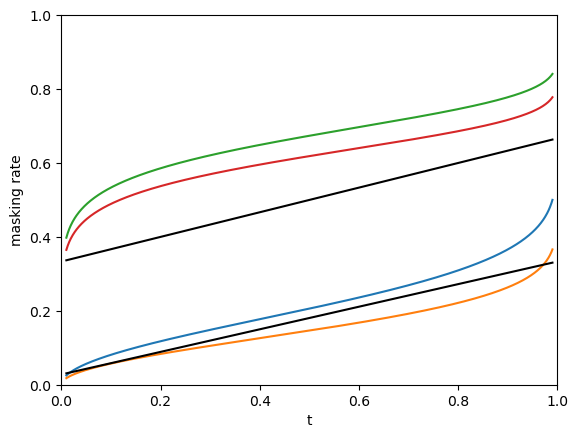

In [400]:
u = torch.linspace(1e-2,1 - 1e-2,1000)
a = [2, 8]
for c1, c0 in itertools.product(a, [16, 32]):
    km = StableKumaraswamy(c1=c1, c0=c0)
    plt.plot(u, km.quantile(u))

r_tgt = 768/2304 + (1536/2304 - 768/2304) * u
r_src = 64/2304 + (768/2304 - 64/2304) * u
plt.plot(u, r_tgt, c = "black")
plt.plot(u, r_src, c = "black")
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('t')
plt.ylabel('masking rate')

In [379]:
a[4]

tensor(1.8889)

In [14]:
# scaling reference

# S = 64 latents, 512 dim, 256 dim_in, 8 layers
# M = 256 latents, 768 dim, 512 dim_in, 16 layers
# L = 512 latents, 1024 dim, 512 

In [1]:
import yaml
from copy import deepcopy
from itertools import product

# -------------------------
# Base YAML (verbatim)
# -------------------------

BASE_YAML = {
    "defaults": {
        "world": {
            "batch_size": 32,
            "field_sizes": {
                "v": "${len:${data.variables}}",
                "t": "${data.sequence_length}",
                "h": 64,
                "w": 120,
            },
            "patch_sizes": {
                "vv": 5,
                "tt": 6,
                "hh": 4,
                "ww": 4,
            },
        },
        "objective": {
            "prior": "dirichlet",
            "c1": 1.0,
            "c0": 5.0,
            "alpha": 0.5,
            "event_dims": ["t"],
        },
        "model": {
            "num_latents": 256,
            "num_layers": 16,
            "num_tails": 8,
            "dim": 768,
            "dim_in": 512,
            "dim_coords": 64,
            "drop_path": 0.25,
            "wavelengths": [
                [1, 16],
                [1, 16],
                [1, 32],
                [1, 64],
            ],
        },
        "data": {
            "sequence_length": 36,
            "variables": [
                "temp_ocn_0a",
                "temp_ocn_3a",
                "temp_ocn_8a",
                "temp_ocn_14a",
                "tauxa",
            ],
            "eval_variables": ["temp_ocn_0a"],
            "max_dirs": 50,
            "eval_data": "piControl",
        },
        "trainer": {
            "seed": 1,
            "job_name": None,
            "stage1_id": None,
            "num_workers": 8,
            "use_wandb": True,
            "wb_project": "einmask",
            "wb_tags": ["sweep"],
            "resume_training": False,
            "val_loss_name": "loss",
            "scheduler_step": "batch",
            "spectral_loss_weight": 0.0,
            "lr": 1e-4,
            "beta1": 0.9,
            "beta2": 0.95,
            "weight_decay": 0.01,
            "schedulers": [
                {
                    "type": "linear",
                    "steps": 5000,
                    "start_factor": 1e-5,
                    "end_factor": 1.0,
                },
                {
                    "type": "cosine",
                    "steps": 295000,
                    "eta_min": 1e-5,
                },
            ],
            "use_ema": True,
            "ema_decay": 0.9999,
            "use_zero": False,
            "save_eval": False,
            "picontrol_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/CMIP6_LENS/CESM2/piControl/temp_ocean_1_2_grid/processed",
            "lens_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/CMIP6_LENS/CESM2/historical_levels/temp_ocean/1_2_grid/all_ensembles",
            "godas_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/enso_data_pacific/godas/temp_ocean/1_2_grid",
            "oras5_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/enso_data_pacific/oras5/temp_ocean/1_2_grid",
            "model_dir": "/mnt/lustre/work/ludwig/jthuemmel54/thesis/runs/",
        },
    },
}

# -------------------------
# Sweep generation
# -------------------------

def generate_tasks():
    task_id = 1
    tasks = {}

    # -------- Block 1: Dirichlet alpha --------
    for alpha in [0.01, 0.1, 0.5, 1.0, 10.0]:
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "objective": {"alpha": alpha, "prior": "dirichlet"},
                "trainer": {"seed": seed, "wb_tags": ["sweep", "dirichlet_alpha"]},
            }
            task_id += 1

    # -------- Block 2: Event dims x alpha --------
    event_sets = [
        ["t"],
        ["h", "w"],
        ["t", "h", "w"],
    ]
    for event_dims, alpha in product(
        event_sets, [0.0, 0.1, 0.3, 0.5, 0.7]
    ):
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "objective": {
                    "event_dims": list(event_dims),
                    "alpha": alpha,
                    "prior": "binomial",
                },
                "trainer": {"seed": seed, "wb_tags": ["sweep", "event_dims"]},
            }
            task_id += 1

    # -------- Block 3: Model x dataset sizes --------
    models = {
        "S": dict(dim=512, dim_in=256, num_latents=64, num_layers=8, batch_size=64),
        "M": dict(dim=768, dim_in=512, num_latents=256, num_layers=16, batch_size=32),
        "L": dict(dim=1024, dim_in=768, num_latents=512, num_layers=24, batch_size=16),
    }

    for model_cfg, max_dirs, steps in product(
        models.values(),
        [20, 60, 100],
        [95000, 195000, 295000],
    ):
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "world": {"batch_size": model_cfg["batch_size"]},
                "model": {
                    "dim": model_cfg["dim"],
                    "dim_in": model_cfg["dim_in"],
                    "num_latents": model_cfg["num_latents"],
                    "num_layers": model_cfg["num_layers"],
                },
                "data": {"max_dirs": max_dirs},
                "trainer": {
                    "seed": seed,
                    "wb_tags": ["sweep", "model_size", "data_size"],
                    "schedulers": [
                        {
                            "type": "linear",
                            "steps": 5000,
                            "start_factor": 1e-5,
                            "end_factor": 1.0,
                        },
                        {
                            "type": "cosine",
                            "steps": steps,
                            "eta_min": 1e-5,
                        },
                    ],
                },
            }
            task_id += 1

    # -------- Block 4: Hyperparameters --------

    # LR sweep
    for lr in [1e-4, 5e-4, 5e-5]:
        tasks[str(task_id)] = {
            "trainer": {"lr": lr, "wb_tags": ["sweep", "lr"]},
        }
        task_id += 1

    # Eta min sweep (cosine scheduler only)
    for eta_min in [1e-5, 1e-6, 1e-7]:
        tasks[str(task_id)] = {
            "trainer": {
                "wb_tags": ["sweep", "eta_min"],
                "schedulers": [
                    {
                        "type": "linear",
                        "steps": 5000,
                        "start_factor": 1e-5,
                        "end_factor": 1.0,
                    },
                    {
                        "type": "cosine",
                        "steps": 295000,
                        "eta_min": eta_min,
                    },
                ]
            }
        }
        task_id += 1

    # Weight decay sweep
    for wd in [0.0, 0.1, 0.05, 0.001]:
        tasks[str(task_id)] = {
            "trainer": {"weight_decay": wd, "wb_tags": ["sweep", "weight_decay"]},
        }
        task_id += 1

    # Drop path sweep
    for dp in [0.0, 0.1, 0.25]:
        tasks[str(task_id)] = {
            "model": {"drop_path": dp},
            "trainer": {"wb_tags": ["sweep", "drop_path"]},
        }
        task_id += 1

    # EMA on/off
    for ema in [True, False]:
        tasks[str(task_id)] = {
            "trainer": {"use_ema": ema, "wb_tags": ["sweep", "use_ema"]},
        }
        task_id += 1

    # Spectral loss weight sweep
    for w in [0.0, 0.1, 0.01]:
        tasks[str(task_id)] = {
            "trainer": {"spectral_loss_weight": w, "wb_tags": ["sweep", "spectral_loss_weight"]},
        }
        task_id += 1

    # -------- Block 5: Patch configs --------
    for hh, ww, tt, vv in product([4, 8], [4, 8], [3, 6], [1, 5]):
        tasks[str(task_id)] = {
            "world": {
                "batch_size": 16,
                "patch_sizes": {
                    "hh": hh,
                    "ww": ww,
                    "tt": tt,
                    "vv": vv,
                },
            },
            "trainer": {"wb_tags": ["sweep", "patch_sizes"]},
        }
        task_id += 1

    return tasks


# -------------------------
# Emit YAML
# -------------------------

def main(outfile="sweep.yaml"):
    yaml_out = deepcopy(BASE_YAML)
    yaml_out.update(generate_tasks())

    with open(outfile, "w") as f:
        yaml.safe_dump(
            yaml_out,
            f,
            sort_keys=False,
            default_flow_style=False,
        )


if __name__ == "__main__":
    main()
